<h2><br>Cross Validation Visualizer</br></h2>

In [1]:
# importing necessary datasets 

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as lgb
from sklearn.metrics import accuracy_score, roc_auc_score

from sklearn.model_selection import (
train_test_split,
TimeSeriesSplit,
KFold,
StratifiedKFold,
GroupKFold,
StratifiedGroupKFold,
)


In [2]:
# reading stroke prediction dataset 
# link to the data set https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset
df = pd.read_csv("healthcare-dataset-stroke-data.csv")

# this is a stroke prediction dataset using information about patients 

In [3]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [15]:
def get_prep_data(df):
    df["ever_married"] = (df["ever_married"].replace("Yes",True).replace("No",False))
    df["gender"] = df["gender"].astype("category")
    df["smoking_status"] = df["smoking_status"].astype("category")
    df["Residence_type"] = df["Residence_type"].astype("category")
    df["work_type"] = df["work_type"].astype("category")
    df["doctor"] = np.random.randint(0,8,size=len(df))
    holdout_ids = df.sample(n=500,random_state = 529).index

    train = (
        df.loc[~df.index.isin(holdout_ids)]
        .sample(frac=1, random_state = 529)
        .sort_values("doctor")
        .reset_index(drop=True)
    )

    holdout = (
        df.loc[df.index.isin(holdout_ids)]
        .sample(frac=1,random_state= 529)
        .sort_values("doctor")
        .reset_index(drop=True)
    )

    return train, holdout

train,holdout = get_prep_data(df)

In [16]:
train.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,doctor
0,65419,Male,73.0,0,1,True,Govt_job,Rural,70.23,28.1,never smoked,0,0
1,30129,Female,62.0,0,0,True,Govt_job,Urban,163.17,25.6,never smoked,0,0
2,65429,Female,66.0,0,0,True,Govt_job,Rural,93.34,27.7,never smoked,0,0
3,32571,Male,33.0,0,0,True,Private,Urban,85.27,25.8,Unknown,0,0
4,51149,Male,70.0,0,0,True,Private,Urban,66.85,29.3,Unknown,0,0


In [17]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4610 entries, 0 to 4609
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   id                 4610 non-null   int64   
 1   gender             4610 non-null   category
 2   age                4610 non-null   float64 
 3   hypertension       4610 non-null   int64   
 4   heart_disease      4610 non-null   int64   
 5   ever_married       4610 non-null   bool    
 6   work_type          4610 non-null   category
 7   Residence_type     4610 non-null   category
 8   avg_glucose_level  4610 non-null   float64 
 9   bmi                4433 non-null   float64 
 10  smoking_status     4610 non-null   category
 11  stroke             4610 non-null   int64   
 12  doctor             4610 non-null   int32   
dtypes: bool(1), category(4), float64(3), int32(1), int64(4)
memory usage: 293.4 KB


In [18]:
def get_X_y(train):
    FEATURES = [
        "gender",
        "age",
        "hypertension",
        "heart_disease",
        "ever_married",
        "work_type",
        "Residence_type",
        "avg_glucose_level",
        "bmi",
        "smoking_status",
    ]
    
    GROUPS = "doctor"
    
    TARGET = "stroke"
    X = train[FEATURES]
    y = train[TARGET]
    groups = train[GROUPS]
    return X,y,groups

<h3><b>fitting the lgb classifier</b></h3>

In [19]:

X, y, groups = get_X_y(train)
clf = lgb.LGBMClassifier(n_estimators = 100)
clf.fit(X,y)


[LightGBM] [Info] Number of positive: 223, number of negative: 4387
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000805 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 635
[LightGBM] [Info] Number of data points in the train set: 4610, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.048373 -> initscore=-2.979229
[LightGBM] [Info] Start training from score -2.979229


LGBMClassifier()

<h3><b>predicting on the training set </b></h3>

In [20]:

pred = clf.predict(X)
pred_prob = clf.predict_proba(X)[:,1]

acc_score = accuracy_score(y, pred)
auc_score = roc_auc_score(y, pred_prob)

print(f"The score on the training set is accurac : {acc_score: 0.4f} and AUC of {auc_score: 0.4f}")

The score on the training set is accurac :  0.9911 and AUC of  0.9997


<h3><b> Model can predict with 99 % accuracy on training set. </b></h3>

<h3><b> Checking out on holdout set </b></h3>

In [22]:
X_holdout , y_holdout , groups_holdout = get_X_y(holdout)


pred = clf.predict(X_holdout)
pred_prob = clf.predict_proba(X_holdout)[:,1]
acc_score = accuracy_score(y_holdout, pred)
auc_score = roc_auc_score(y_holdout, pred_prob)
                         
print(f"The score on the training set is accurac : {acc_score: 0.4f} and AUC of {auc_score: 0.4f}")

The score on the training set is accurac :  0.9380 and AUC of  0.7802


<h3><b> Here the model is not so predicting better in holdout set . </b>
<b>Now we  will split training data into training and validations set</b></h3>

In [24]:
X, y ,groups = get_X_y(train)

X_tr , X_val , y_tr , y_val = train_test_split(X, y, test_size = 0.1)
clf = lgb.LGBMClassifier(n_estimators = 100 , max_depth = 3)
clf.fit(X_tr, y_tr)
pred = clf.predict(X_val)
pred_prob = clf.predict_proba(X_val)[:,1]
acc_score = accuracy_score(y_val , pred)
auc_score = roc_auc_score(y_val , pred_prob)

print(f"The score on the training set is accurac : {acc_score: 0.4f} and AUC of {auc_score: 0.4f}")

[LightGBM] [Info] Number of positive: 201, number of negative: 3948
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000671 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 635
[LightGBM] [Info] Number of data points in the train set: 4149, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.048445 -> initscore=-2.977659
[LightGBM] [Info] Start training from score -2.977659
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

<h5><b> Here the output is quite good as we expect our model to get but there could be change that some of the parameter might get over fit where cross validation comes in. </b></h5>

<h2><b> Cross Validation </b></h2>

In [30]:
from matplotlib.patches import Patch
cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm

def visualize_groups(classes, groups, name):
    # Visualize dataset groups
    fig, ax = plt.subplots()
    ax.scatter(
        range(len(groups)),
        [0.5] * len(groups),
        c=groups,
        marker="_",
        lw=50,
        cmap=cmap_data,
    )
    ax.scatter(
        range(len(groups)),
        [3.5] * len(groups),
        c=classes,
        marker="_",
        lw=50,
        cmap=cmap_data,
    )
    ax.set(
        ylim=[-1, 5],
        yticks=[0.5, 3.5],
        yticklabels=["Data\ngroup", "Data\nclass"],
        xlabel="Sample index",
    )
def plot_cv_indices(cv, X, y, group, ax, n_splits, lw=25):
    """Create a sample plot for indices of a cross-validation object."""

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y, groups=group)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(
            range(len(indices)),
            [ii + 0.5] * len(indices),
            c=indices,
            marker="_",
            lw=lw,
            cmap=cmap_cv,
            vmin=-0.2,
            vmax=1.2,
        )

# Plot the data classes and groups at the end
    ax.scatter(
        range(len(X)), [ii + 1.5] * len(X), c=y, marker="_", lw=lw, cmap=cmap_data
    )

    ax.scatter(
        range(len(X)), [ii + 2.5] * len(X), c=group, marker="_", lw=lw, cmap=cmap_data
    )

    # Formatting
    yticklabels = list(range(n_splits)) + ["class", "group"]
    ax.set(
        yticks=np.arange(n_splits + 2) + 0.5,
        yticklabels=yticklabels,
        xlabel="Sample index",
        ylabel="CV iteration",
        ylim=[n_splits + 2.2, -0.2],
        xlim=[0, 100],
    )
    ax.set_title("{}".format(type(cv).__name__), fontsize=15)
    return ax

def plot_cv(cv, X, y, groups, n_splits=5):
    this_cv = cv(n_splits=n_splits)
    fig, ax = plt.subplots(figsize=(15, 5))
    plot_cv_indices(this_cv, X, y, groups, ax, n_splits)

    ax.legend(
        [Patch(color=cmap_cv(0.8)), Patch(color=cmap_cv(0.02))],
        ["Testing set", "Training set"],
        loc=(1.02, 0.8),
    )
    plt.tight_layout()
    fig.subplots_adjust(right=0.7)
    plt.show()

def get_fake_X_y():
    # Fake Generate the class/group data for an example
    n_points = 100
    X_ = np.random.randn(100, 10)

    percentiles_classes = [0.1, 0.9]
    y_ = np.hstack([[ii] * int(100 * perc) for ii, perc in enumerate(percentiles_classes)])

    # Evenly spaced groups repeated once
    groups_ = np.hstack([[ii] * 10 for ii in range(10)])
    return X_, y_, groups_

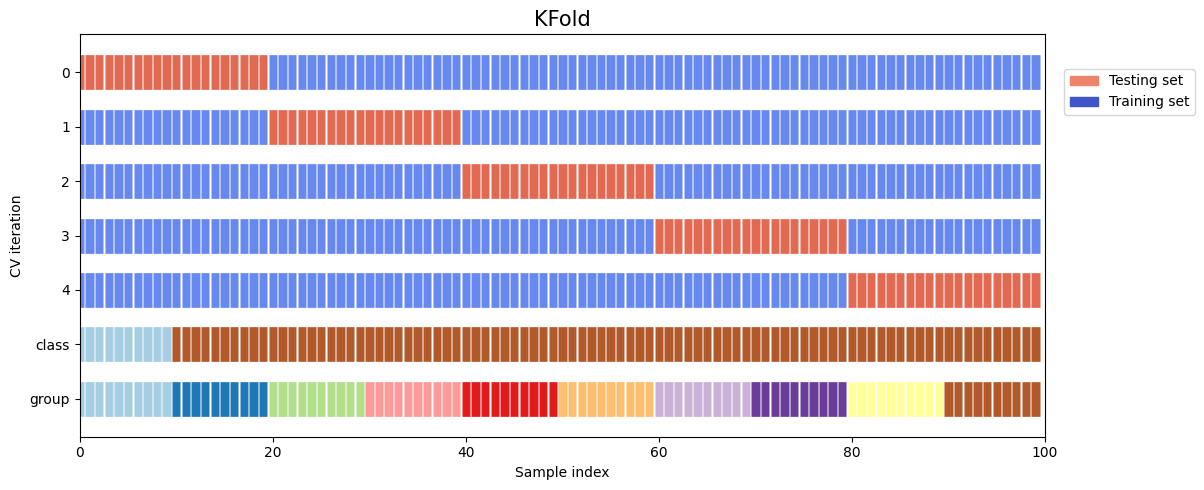

In [31]:
# A.KFOld: split dataset into K consecutive folds(without suffling by default.)
# we can choose to suffle and split number
kf = KFold()
X_, y_ , groups_ = get_fake_X_y()
plot_cv(KFold, X_, y_, groups_)

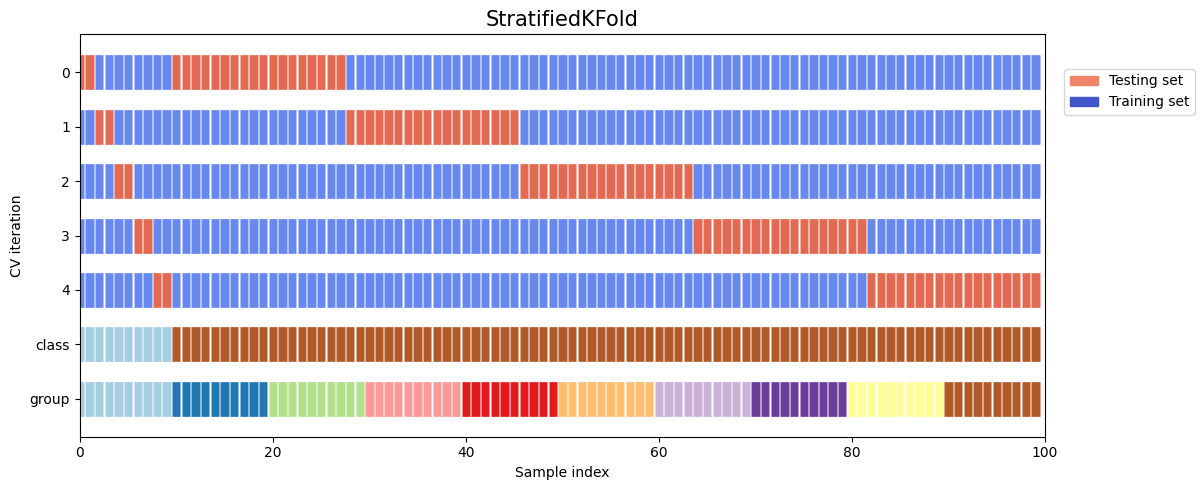

In [32]:
# Stratified KFold 
# KFold but the folds are made by preserving the percentage of samples for each classes.
# we can choose to suffle and number of split size
skf = StratifiedKFold()
X_, y_ , groups_ = get_fake_X_y()
plot_cv(StratifiedKFold, X_ , y_, groups_)

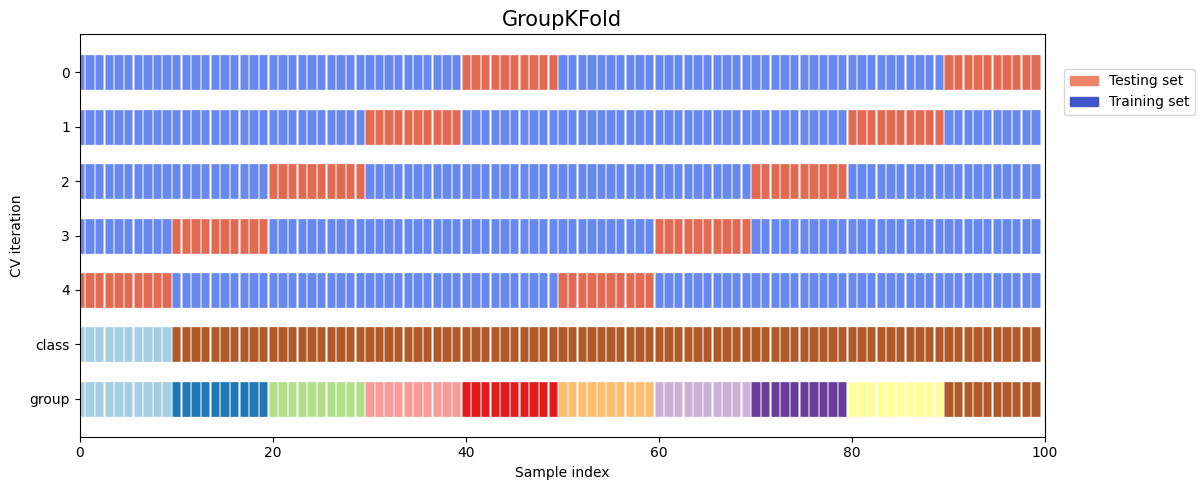

In [34]:
# Group KFold 
# The folds are approximately balenced in the sense that the number of distinct groups 
       # is approximately the same in each fold.
# we cannot choose if suffle and number of split size
gkf = GroupKFold()
X_ , y_ , groups_ = get_fake_X_y()
plot_cv(GroupKFold, X_ , y_ ,groups_)

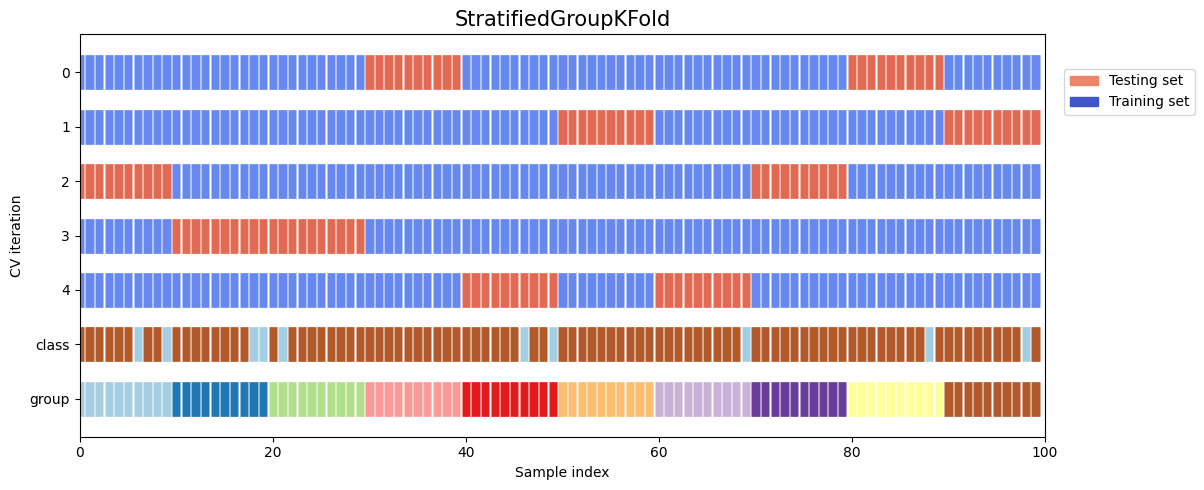

In [36]:
#Stratified group kfold
# The difference between GroupKFold and StratifiedGroupKFold is that the former attempts to create balanced folds such that the
# number of distinct groups is approximately the  same in each fold, whereas StratifiedGroupKFold attempts to create folds which preserve
# the percentage of samples for each class as much as possible given the constraint of  non-overlapping groups between splits.

gskf = StratifiedGroupKFold()
X_ , y_ ,groups_ = get_fake_X_y()
np.random.shuffle(y_)
plot_cv(StratifiedGroupKFold, X_ ,y_, groups_)

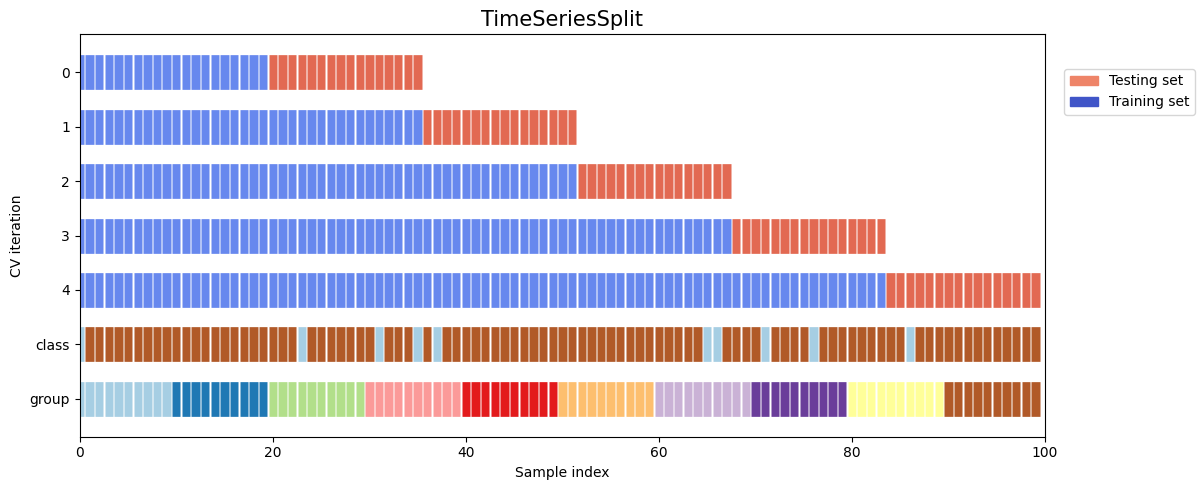

In [37]:
# Time series split

tss = TimeSeriesSplit()
X_ , y_ , groups = get_fake_X_y()
np.random.shuffle(y_)
plot_cv(TimeSeriesSplit, X_ , y_ ,groups_ )

<h4><b>Using cross validation of out data.  </b></h4> 
<h5><b> We will be using stratifiedgroupkfold CV in this data with shuffle on </b></h5>

In [39]:
sgk = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=529)

X, y, groups = get_X_y(train)

fold = 0
aucs = []
for train_idx, val_idx in sgk.split(X, y, groups):
    X_tr = X.loc[train_idx]
    y_tr = y.loc[train_idx]
    
    X_val = X.loc[val_idx]
    y_val = y.loc[val_idx]

    # Fit Model on Train
    clf = lgb.LGBMClassifier(n_estimators=100)
    clf.fit(X_tr, y_tr)
    pred = clf.predict(X_val)
    pred_prob = clf.predict_proba(X_val)[:, 1]
    acc_score = accuracy_score(y_val, pred)
    auc_score = roc_auc_score(y_val, pred_prob)
    print(f"======= Fold {fold} ========")
    print(
        f"Our accuracy on the validation set is {acc_score:0.4f} and AUC is {auc_score:0.4f}"
    )
    fold += 1
    aucs.append(auc_score)
oof_auc = np.mean(aucs)
print(f'Our out of fold AUC score is {oof_auc:0.4f}')

[LightGBM] [Info] Number of positive: 201, number of negative: 3819
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000351 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 635
[LightGBM] [Info] Number of data points in the train set: 4020, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.050000 -> initscore=-2.944439
[LightGBM] [Info] Start training from score -2.944439
======= Fold 0 ========
Our accuracy on the validation set is 0.9525 and AUC is 0.8029
[LightGBM] [Info] Number of positive: 175, number of negative: 3298
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000302 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 631
[LightGBM] [Info] Number of data 